# 라이브러리 가져오기

In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers.legacy import SGD
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# 함수 정의

In [2]:
# 이미지 폴더에서 이미지 파일 경로를 가져오는 함수
def get_image_paths(folder_path):
    return [os.path.join(folder_path, filename) 
            for filename in os.listdir(folder_path) 
            if filename.endswith('.jpg')]
    
# 이미지를 로드하고 전처리하는 함수
def load_and_preprocess_image(image_path, size=(224, 224)):
    try:
        image = Image.open(image_path).resize(size)
        return np.array(image) / 255.0
    except Exception as e:
        print(f"Error loading image at {image_path}: {e}")
        return None



# 메타데이터를 로드하는 함수
def load_metadata(file_path):
    df = pd.read_csv(file_path)
    df['age'] = df['age'].fillna(df['age'].mean())
    df['age_normalized'] = (df['age'] - df['age'].mean()) / df['age'].std()
    return df
    
# 레이블을 인코딩하는 함수
def encode_labels(df, columns):
    encoders = {}
    for col in columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders


# 이미지를 증강하고 처리하는 함수
def augment_and_process_images(images, category, data_gen, num_to_augment, process_function):
    augmented_images = []
    for x in images:
        x = x.reshape((1,) + x.shape)
        for _ in range(num_to_augment):
            img = data_gen.flow(x, batch_size=1).next()[0]
            # 증강된 이미지를 처리
            processed_img = process_function(img_to_array(img))
            augmented_images.append(processed_img)
    return augmented_images

# 메타데이터에 이미지 경로를 추가하는 함수
def add_image_paths_to_metadata(metadata_df, image_paths):
    # 이미지 ID를 기반으로 경로를 찾아 'path' 열에 추가
    metadata_df['path'] = metadata_df['image_id'].apply(
        lambda x: next((path for path in image_paths if x in path), None))
    return metadata_df


# 랜덤 드롭아웃을 적용하는 함수
def apply_random_dropout(metadata, dropout_rate=0.1, unknown_value=-1):
    """
    metadata: 메타데이터 numpy 배열
    dropout_rate: 드롭아웃 확률
    unknown_value: 알 수 없는 값에 대한 표시 (예: -1)
    """
    for i in range(metadata.shape[1]):
        for j in range(metadata.shape[0]):
            if random.random() < dropout_rate:
                metadata[j, i] = unknown_value
    return metadata


# 모델 학습 중 일정 배치 단계마다 학습을 중단시키는 콜백 클래스
class FixedStepStopping(Callback):
    def __init__(self, step):
        super(FixedStepStopping, self).__init__()
        self.step = step

    def on_batch_end(self, batch, logs=None):
        if (batch + 1) % self.step == 0:
            self.model.stop_training = True



# 모델 성능 그래프를 그리는 함수
def plot_performance(history, val_accuracy, val_loss, title):
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=val_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.axhline(y=val_loss, color='r', linestyle='--', label='Test Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()





def remove_noise_and_find_contours_from_array(image_array, threshold=10, blur_kernel_size=3, dilate_iterations=0):
    # 이미지 배열이 이미 0에서 1 사이로 정규화되어 있다고 가정
    src = (image_array * 255).astype(np.uint8)
    # 그레이스케일로 변환
    grayScale = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    # 모폴로지 필터링을 위한 커널
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    # 블랙햇 모폴로지 연산으로 헤어 윤곽 추출
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # 윤곽 강화를 위한 임계값 처리
    _, thresh2 = cv2.threshold(blackhat, threshold, 255, cv2.THRESH_BINARY)
    # 임계값으로 얻은 마스크를 dilate하여 inpainting할 영역을 조정
    if dilate_iterations > 0:
        thresh2 = cv2.dilate(thresh2, None, iterations=dilate_iterations)
    # inpainting으로 노이즈 제거
    dst = cv2.inpaint(src, thresh2, 1, cv2.INPAINT_TELEA)
    # 윤곽선 검출을 위한 그레이스케일 변환 및 블러 처리
    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
    blurred = cv2.medianBlur(gray, blur_kernel_size)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    contour_image = dst.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    return dst, contour_image





# 이미지 및 메타데이터 불러오기

In [3]:
# 데이터 로딩
folder_path_1 = '/Users/choejong-gyu/Downloads/archive/HAM10000_images'

metadata_file_path = '/Users/choejong-gyu/Downloads/archive/HAM10000_metadata.csv'

image_paths = get_image_paths(folder_path_1)
metadata_df = load_metadata(metadata_file_path)
metadata_df, encoders = encode_labels(metadata_df, ['sex', 'localization', 'dx'])
metadata_df = add_image_paths_to_metadata(metadata_df, image_paths)

In [4]:
metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,age_normalized,sex_encoded,localization_encoded,dx_encoded,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1.662870,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,1.367366,1,4,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,-0.701161,1,0,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,-0.701161,1,0,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,-0.701161,1,0,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,1.662870,1,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...


# EDA

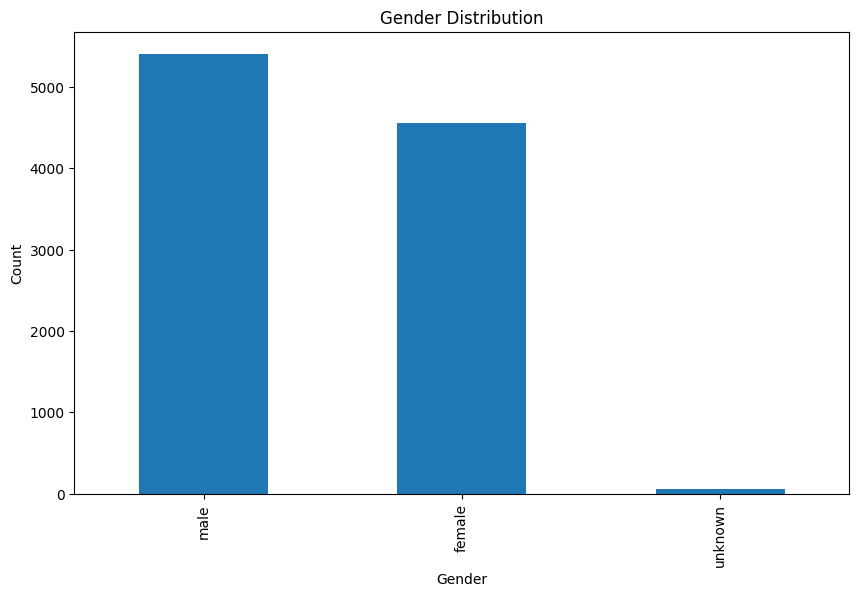

In [5]:
import matplotlib.pyplot as plt

# 성별(sex)별 데이터 수를 가져옵니다.
sex_counts = metadata_df['sex'].value_counts()

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 생성
sex_counts.plot(kind='bar')

# 그래프 제목과 레이블 설정
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# 그래프 표시
plt.show()


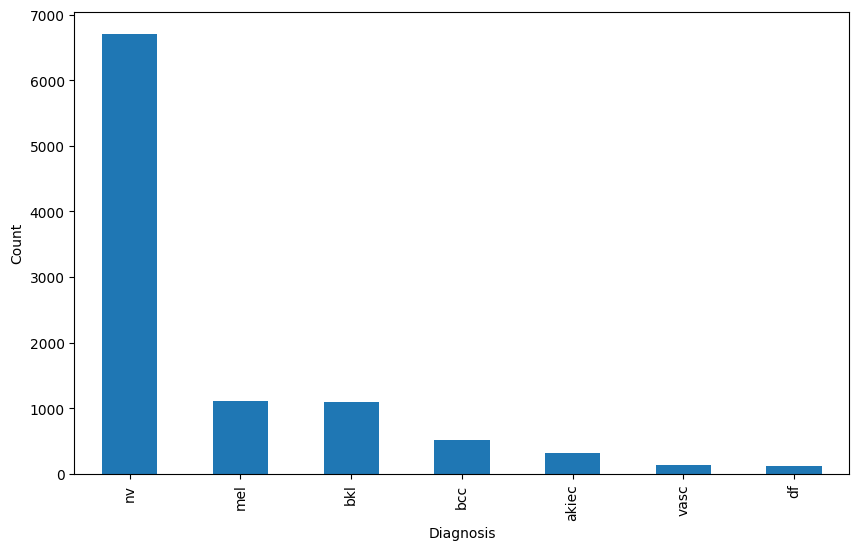

In [6]:
import matplotlib.pyplot as plt

# 진단 코드(dx)별 데이터 수를 가져옵니다.
diagnosis_counts = metadata_df['dx'].value_counts()

# 그래프 크기 설정
plt.figure(figsize=(10, 6))

# 막대 그래프 생성
diagnosis_counts.plot(kind='bar')

# 그래프 제목과 레이블 설정

plt.xlabel('Diagnosis')
plt.ylabel('Count')

# 그래프 표시
plt.show()


# 리샘플링

In [7]:


resampled_samples = pd.DataFrame()

# 클래스별로 500개씩 맞추기
for cls in metadata_df['dx'].unique():
    cls_samples = metadata_df[metadata_df['dx'] == cls]
    if len(cls_samples) < 300:
        # 오버샘플링
        resampled = cls_samples.sample(n=300, replace=True)
    else:
        # 언더샘플링
        resampled = cls_samples.sample(n=300)
    resampled_samples = pd.concat([resampled_samples, resampled], ignore_index=True)

# 이미지 경로 업데이트
resampled_samples = add_image_paths_to_metadata(resampled_samples, get_image_paths(folder_path_1))


In [8]:
resampled_samples

,lesion_id,image_id,dx,dx_type,age,sex,localization,age_normalized,sex_encoded,localization_encoded,dx_encoded,path
0,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown,0.776358,1,13,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
1,HAM_0002042,ISIC_0028662,bkl,confocal,75.0,female,face,1.367366,0,5,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
2,HAM_0001665,ISIC_0031212,bkl,histo,50.0,male,lower extremity,-0.110154,1,9,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
3,HAM_0003392,ISIC_0030240,bkl,histo,70.0,male,scalp,1.071862,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
4,HAM_0001073,ISIC_0027990,bkl,histo,55.0,male,scalp,0.185350,1,11,2,/Users/choejong-gyu/Downloads/archive/HAM10000...
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,HAM_0001176,ISIC_0028644,akiec,histo,65.0,female,abdomen,0.776358,0,0,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
2096,HAM_0003107,ISIC_0030844,akiec,histo,80.0,female,upper extremity,1.662870,0,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
2097,HAM_0000918,ISIC_0029133,akiec,histo,65.0,female,face,0.776358,0,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...
2098,HAM_0001383,ISIC_0027700,akiec,histo,80.0,male,upper extremity,1.662870,1,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...


In [9]:
# 데이터 증강을 위한 설정
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [11]:
augmented_images = []
augmented_metadata = []

for index, row in resampled_samples.iterrows():
    original_image = load_and_preprocess_image(row['path'])
    augmented_image = data_gen.flow(np.expand_dims(original_image, 0), batch_size=1).next()[0]
    
    # 원본 이미지 추가
    augmented_images.append(original_image)
    augmented_metadata.append(row)
    
    # 증강된 이미지 추가
    augmented_images.append(augmented_image)
    augmented_metadata.append(row)

# 증강된 이미지와 메타데이터를 DataFrame으로 변환
augmented_metadata_df = pd.DataFrame(augmented_metadata)
augmented_metadata_df['processed_image'] = augmented_images


In [12]:
augmented_metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,age_normalized,sex_encoded,localization_encoded,dx_encoded,path,processed_image
0,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown,0.776358,1,13,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.9058823529411765, 0.9333333333333333, 0.9..."
0,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown,0.776358,1,13,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.9143939, 0.9261586, 0.9500222], [0.907952..."
1,HAM_0002042,ISIC_0028662,bkl,confocal,75.0,female,face,1.367366,0,5,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6745098039215687, 0.5019607843137255, 0.6..."
1,HAM_0002042,ISIC_0028662,bkl,confocal,75.0,female,face,1.367366,0,5,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6666667, 0.48775387, 0.59093577], [0.6691..."
2,HAM_0001665,ISIC_0031212,bkl,histo,50.0,male,lower extremity,-0.110154,1,9,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6274509803921569, 0.5411764705882353, 0.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,HAM_0000918,ISIC_0029133,akiec,histo,65.0,female,face,0.776358,0,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.7236835, 0.49532914, 0.55113447], [0.7241..."
2098,HAM_0001383,ISIC_0027700,akiec,histo,80.0,male,upper extremity,1.662870,1,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6705882352941176, 0.5568627450980392, 0.5..."
2098,HAM_0001383,ISIC_0027700,akiec,histo,80.0,male,upper extremity,1.662870,1,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.77516806, 0.66388965, 0.6533306], [0.7691..."
2099,HAM_0006217,ISIC_0031043,akiec,histo,85.0,male,face,1.958373,1,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.615686274509804, 0.40784313725490196, 0.4..."


# 리샘플링 + 데이터 증강된 이미지에 윤곽선 및 노이즈 제거

In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed



def process_image(image):
    # 이미지 처리 함수 `remove_noise_and_find_contours_from_array`를 호출
    processed_image, _ = remove_noise_and_find_contours_from_array(image)  # 수정된 부분
    # 처리된 이미지를 0에서 1 사이로 정규화
    processed_image_normalized = processed_image / 255.0
    return processed_image_normalized
# 이미지 리스트를 작은 배치로 나누는 함수
def chunked_iterable(iterable, size):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]

# 이미지 처리 및 배치 처리 실행 함수
def process_images_in_batches(images, batch_size=500):
    processed_images = []
    for image_batch in chunked_iterable(images, batch_size):
        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = [executor.submit(process_image, img) for img in image_batch]
            for future in as_completed(futures):
                processed_images.append(future.result())
        # 여기서 필요하다면 메모리 정리 작업을 수행할 수 있습니다.
    return processed_images

images = [np.random.rand(224, 224, 3) for _ in range(4200)]  # 예시 데이터
processed_images = process_images_in_batches(images, 500)
print("Processed Images Shape:", np.array(processed_images).shape)


Processed Images Shape: (4200, 224, 224, 3)


In [14]:
augmented_metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,age_normalized,sex_encoded,localization_encoded,dx_encoded,path,processed_image
0,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown,0.776358,1,13,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.9058823529411765, 0.9333333333333333, 0.9..."
0,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown,0.776358,1,13,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.9143939, 0.9261586, 0.9500222], [0.907952..."
1,HAM_0002042,ISIC_0028662,bkl,confocal,75.0,female,face,1.367366,0,5,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6745098039215687, 0.5019607843137255, 0.6..."
1,HAM_0002042,ISIC_0028662,bkl,confocal,75.0,female,face,1.367366,0,5,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6666667, 0.48775387, 0.59093577], [0.6691..."
2,HAM_0001665,ISIC_0031212,bkl,histo,50.0,male,lower extremity,-0.110154,1,9,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6274509803921569, 0.5411764705882353, 0.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,HAM_0000918,ISIC_0029133,akiec,histo,65.0,female,face,0.776358,0,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.7236835, 0.49532914, 0.55113447], [0.7241..."
2098,HAM_0001383,ISIC_0027700,akiec,histo,80.0,male,upper extremity,1.662870,1,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6705882352941176, 0.5568627450980392, 0.5..."
2098,HAM_0001383,ISIC_0027700,akiec,histo,80.0,male,upper extremity,1.662870,1,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.77516806, 0.66388965, 0.6533306], [0.7691..."
2099,HAM_0006217,ISIC_0031043,akiec,histo,85.0,male,face,1.958373,1,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.615686274509804, 0.40784313725490196, 0.4..."


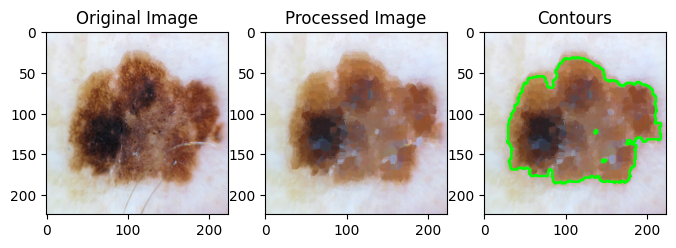

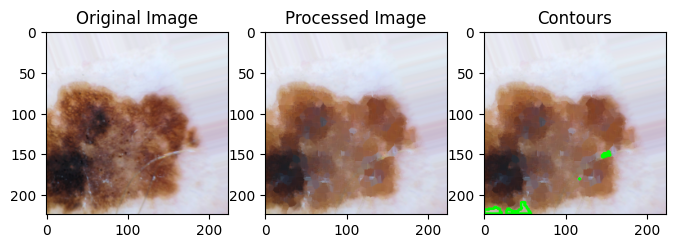

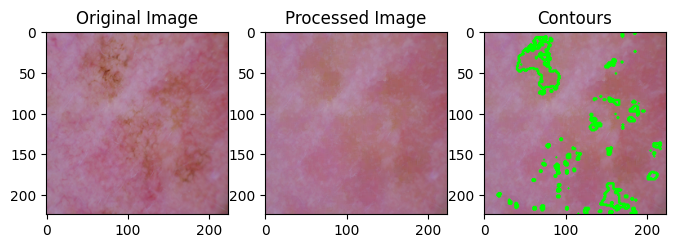

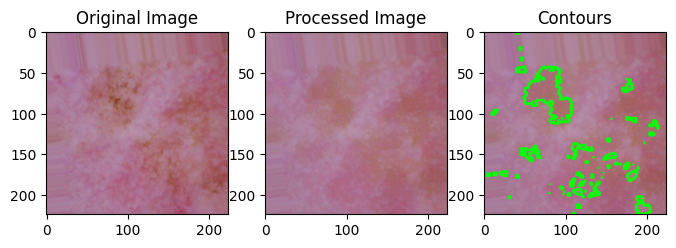

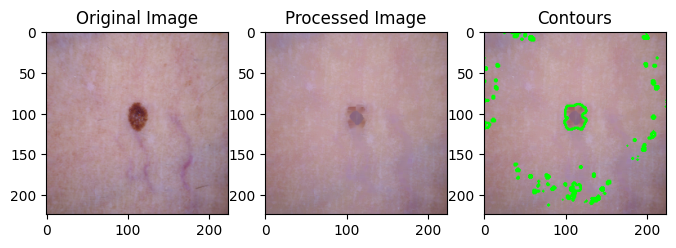

In [15]:
import matplotlib.pyplot as plt

# 이미지 처리 및 시각화
def process_and_visualize_images(images):
    for image in images:
        # 이미지 처리 함수를 적용
        processed_image, contour_image = remove_noise_and_find_contours_from_array(image)
        
        # 원본 이미지 시각화
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        
        # 이미지 처리 후 시각화
        plt.subplot(1, 3, 2)
        plt.imshow(processed_image)
        plt.title("Processed Image")
        
        # 윤곽선 검출 결과 시각화
        plt.subplot(1, 3, 3)
        plt.imshow(contour_image)
        plt.title("Contours")
        
        plt.show()

# 예시 이미지 리스트
example_images = augmented_metadata_df['processed_image'].iloc[:5].values

# 이미지 처리 및 시각화 실행
process_and_visualize_images(example_images)


In [16]:
augmented_metadata_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,age_normalized,sex_encoded,localization_encoded,dx_encoded,path,processed_image
0,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown,0.776358,1,13,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.9058823529411765, 0.9333333333333333, 0.9..."
0,HAM_0002774,ISIC_0029683,bkl,histo,65.0,male,unknown,0.776358,1,13,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.9143939, 0.9261586, 0.9500222], [0.907952..."
1,HAM_0002042,ISIC_0028662,bkl,confocal,75.0,female,face,1.367366,0,5,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6745098039215687, 0.5019607843137255, 0.6..."
1,HAM_0002042,ISIC_0028662,bkl,confocal,75.0,female,face,1.367366,0,5,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6666667, 0.48775387, 0.59093577], [0.6691..."
2,HAM_0001665,ISIC_0031212,bkl,histo,50.0,male,lower extremity,-0.110154,1,9,2,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6274509803921569, 0.5411764705882353, 0.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,HAM_0000918,ISIC_0029133,akiec,histo,65.0,female,face,0.776358,0,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.7236835, 0.49532914, 0.55113447], [0.7241..."
2098,HAM_0001383,ISIC_0027700,akiec,histo,80.0,male,upper extremity,1.662870,1,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.6705882352941176, 0.5568627450980392, 0.5..."
2098,HAM_0001383,ISIC_0027700,akiec,histo,80.0,male,upper extremity,1.662870,1,14,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.77516806, 0.66388965, 0.6533306], [0.7691..."
2099,HAM_0006217,ISIC_0031043,akiec,histo,85.0,male,face,1.958373,1,5,0,/Users/choejong-gyu/Downloads/archive/HAM10000...,"[[[0.615686274509804, 0.40784313725490196, 0.4..."


In [17]:
# 데이터프레임에서 각 dx_encoded 값에 따른 dx (diagnosis) 값을 찾아내기
dx_encoded_to_dx = augmented_metadata_df.groupby('dx_encoded')['dx'].first().to_dict()

# 모든 dx_encoded 값과 해당하는 dx 값 출력
for dx_encoded_value, dx_value in dx_encoded_to_dx.items():
    print(f"dx_encoded: {dx_encoded_value}, dx: {dx_value}")


dx_encoded: 0, dx: akiec
dx_encoded: 1, dx: bcc
dx_encoded: 2, dx: bkl
dx_encoded: 3, dx: df
dx_encoded: 4, dx: mel
dx_encoded: 5, dx: nv
dx_encoded: 6, dx: vasc


In [18]:
augmented_metadata_df['dx_encoded'].value_counts()

dx_encoded
2    600
5    600
3    600
4    600
6    600
1    600
0    600
Name: count, dtype: int64

In [19]:
augmented_metadata_df, encoders = encode_labels(augmented_metadata_df, ['sex', 'localization', 'dx'])

In [20]:
from sklearn.preprocessing import MinMaxScaler

# 나이 컬럼 [0, 1] 범위로 스케일링
scaler = MinMaxScaler()
augmented_metadata_df['age_scaled'] = scaler.fit_transform(augmented_metadata_df[['age']])


In [20]:
augmented_metadata_df[['age_scaled','sex_encoded','localization_encoded','dx_encoded']]

,age_scaled,sex_encoded,localization_encoded,dx_encoded
0,0.882353,0,5,2
0,0.882353,0,5,2
1,0.411765,0,9,2
1,0.411765,0,9,2
2,0.882353,0,5,2
...,...,...,...,...
2097,0.470588,0,5,0
2098,0.705882,1,5,0
2098,0.705882,1,5,0
2099,0.823529,1,8,0


In [30]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

def create_model_with_interactions_inception_v3(input_shape, metadata_shape, dropout_rate=0.5):
    # 이미지 처리 부분
    image_input = Input(shape=input_shape, name='image_input')
    # InceptionV3 모델을 사용합니다.
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x_image = base_model(image_input)
    x_image = GlobalAveragePooling2D()(x_image)
    x_image = Dense(128, activation='relu')(x_image)
    x_image = Dropout(dropout_rate)(x_image)
    x_image = Dense(64, activation='relu')(x_image)
    

    # 메타데이터 처리 부분
    metadata_input = Input(shape=metadata_shape, name='metadata_input')
    x_metadata = Dense(64, activation='relu')(metadata_input)
    x_metadata = Dropout(dropout_rate)(x_metadata)

    # 상호작용 부분
    combined = Concatenate()([x_image, x_metadata])
    combined = Dense(64, activation='relu')(combined)

    # 출력 레이어
    combined_output = Dense(7, activation='softmax')(combined)

    model = Model(inputs=[image_input, metadata_input], outputs=combined_output)

    return model


In [31]:
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# def create_model_with_interactions_inception_resnetv2(input_shape, metadata_shape, dropout_rate=0.5):
#     # 이미지 처리 부분
#     image_input = Input(shape=input_shape, name='image_input')
#     base_model = InceptionResNetV2(weights='imagenet', include_top=False)
#     x_image = Dense(512, activation='relu')(x)
#     x_metadata = Dropout(dropout_rate)(x_metadata)  
    
#     x_image = base_model(image_input)
#     x_image = GlobalAveragePooling2D()(x_image)
   
    
#     # 메타데이터 처리 부분
#     metadata_input = Input(shape=metadata_shape, name='metadata_input')
#     x_metadata = Dense(64, activation='relu')(metadata_input)
#     x_metadata = Dropout(dropout_rate)(x_metadata)  

    
#     # 상호작용 부분
#     combined = Concatenate()([x_image, x_metadata])
#     combined = Dense(32, activation='relu')(combined)
#     combined_output = Dense(7, activation='softmax')(combined)
    
#     model = Model(inputs=[image_input, metadata_input], outputs=combined_output)
    
#     return model


In [32]:
# from tensorflow.keras.applications.densenet import DenseNet201
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, BatchNormalization
# from tensorflow.keras.models import Model

# def create_model_with_interactions_densenet201(input_shape, metadata_shape, dropout_rate=0.3):
#     # 이미지 처리 부분
#     image_input = Input(shape=input_shape, name='image_input')
#     base_model = DenseNet201(weights='imagenet', include_top=False)
#     x_image = base_model(image_input)
#     x_image = GlobalAveragePooling2D()(x_image)
   
#     # 메타데이터 처리 부분
#     metadata_input = Input(shape=metadata_shape, name='metadata_input')
#     x_metadata = Dense(32, activation='relu')(metadata_input)
#     x_metadata = BatchNormalization()(x_metadata)  # 배치 정규화 추가
#     x_metadata = Dropout(dropout_rate)(x_metadata)

#     # 상호작용 부분
#     combined = Concatenate()([x_image, x_metadata])
#     combined = Dense(32, activation='relu')(combined)
#     combined = BatchNormalization()(combined)  # 배치 정규화 추가
#     combined_output = Dense(7, activation='softmax')(combined)
    
#     model = Model(inputs=[image_input, metadata_input], outputs=combined_output)
    
#     return model

In [33]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
# from tensorflow.keras.models import Model

# def create_model_with_resnet50(input_shape, metadata_shape, dropout_rate=0.5):
#     # 이미지 처리 부분
#     image_input = Input(shape=input_shape, name='image_input')
#     base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
    
#     x_image = base_model.output
#     x_image = GlobalAveragePooling2D()(x_image)
    
#     # 메타데이터 처리 부분
#     metadata_input = Input(shape=metadata_shape, name='metadata_input')
#     x_metadata = Dense(64, activation='relu')(metadata_input)
#     x_metadata = Dropout(dropout_rate)(x_metadata)
    
#     # 상호작용 부분
#     combined = Concatenate()([x_image, x_metadata])
#     combined = Dense(32, activation='relu')(combined)
#     combined_output = Dense(7, activation='softmax')(combined)
    
#     # 모델 구성
#     model = Model(inputs=[image_input, metadata_input], outputs=combined_output)
    
#     return model


In [34]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.optimizers import SGD

# 레이블 인코딩 및 원-핫 인코딩
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(augmented_metadata_df['dx'])  # 'dx' 열을 기반으로 레이블 인코딩
labels_one_hot = to_categorical(labels_encoded)  # 인코딩된 레이블을 원-핫 인코딩

# 이미지 데이터 준비
images_np = np.array([img for img in augmented_metadata_df['processed_image']])  # 이미지 데이터를 NumPy 배열로 변환


# 메타데이터 준비
meta_data_np = augmented_metadata_df[['age_scaled', 'sex_encoded', 'localization_encoded']].values

# 전체 데이터 세트 인덱스 생성
indices = np.arange(len(images_np))

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping

# ReduceLROnPlateau 콜백 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # 학습률을 20%로 감소
    patience=3,  # 검증 손실이 3 에포크 동안 개선되지 않으면 학습률 조정
    min_lr=0.001,  # 학습률의 하한선
    verbose=1)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  
    verbose=1,
    restore_best_weights=True)  # 가장 좋은 가중치로 복원


In [36]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np

# 훈련 세트와 테스트 세트 분할
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    images_np,
    labels_one_hot,
    meta_data_np,
    test_size=0.2,
    stratify=labels_encoded,  # 레이블을 기준으로 계층화
    random_state=42
)

In [37]:
import tensorflow as tf

# GPU 디바이스 목록 얻기
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # GPU 메모리 할당을 동적으로 조절
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # 프로그램이 시작된 후에 설정해야 할 수 있습니다.
        print(e)


1 Physical GPUs, 1 Logical GPUs


Training on fold 1...
Epoch 1/50


2024-01-31 21:01:49.140049: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


336/336 [==============================] - ETA: 0s - loss: 2.1846 - accuracy: 0.2266
Epoch 1: val_accuracy improved from -inf to 0.27976, saving model to best_model2.h5


/Users/choejong-gyu/miniforge3/envs/tf_metal/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


336/336 [==============================] - 73s 179ms/step - loss: 2.1846 - accuracy: 0.2266 - val_loss: 1.8891 - val_accuracy: 0.2798 - lr: 0.0010
Epoch 2/50
336/336 [==============================] - ETA: 0s - loss: 1.6090 - accuracy: 0.4100
Epoch 2: val_accuracy improved from 0.27976 to 0.46131, saving model to best_model2.h5
336/336 [==============================] - 49s 146ms/step - loss: 1.6090 - accuracy: 0.4100 - val_loss: 1.3480 - val_accuracy: 0.4613 - lr: 0.0010
Epoch 3/50
336/336 [==============================] - ETA: 0s - loss: 1.3699 - accuracy: 0.4918
Epoch 3: val_accuracy improved from 0.46131 to 0.54167, saving model to best_model2.h5
336/336 [==============================] - 46s 137ms/step - loss: 1.3699 - accuracy: 0.4918 - val_loss: 1.1773 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 4/50
336/336 [==============================] - ETA: 0s - loss: 1.2148 - accuracy: 0.5551
Epoch 4: val_accuracy improved from 0.54167 to 0.63542, saving model to best_model2.h5
336/336 [=

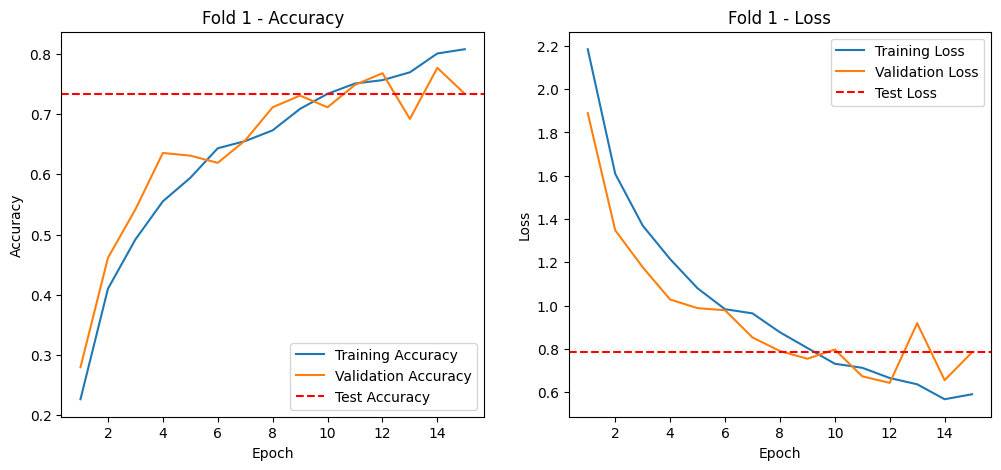

Training on fold 2...
Epoch 1/50


2024-01-31 21:15:39.804289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


336/336 [==============================] - ETA: 0s - loss: 2.2228 - accuracy: 0.2217
Epoch 1: val_accuracy did not improve from 0.77679
336/336 [==============================] - 75s 175ms/step - loss: 2.2228 - accuracy: 0.2217 - val_loss: 1.7095 - val_accuracy: 0.3229 - lr: 0.0010
Epoch 2/50
336/336 [==============================] - ETA: 0s - loss: 1.7004 - accuracy: 0.3653
Epoch 2: val_accuracy did not improve from 0.77679
336/336 [==============================] - 49s 146ms/step - loss: 1.7004 - accuracy: 0.3653 - val_loss: 1.5269 - val_accuracy: 0.4449 - lr: 0.0010
Epoch 3/50
336/336 [==============================] - ETA: 0s - loss: 1.4577 - accuracy: 0.4438
Epoch 3: val_accuracy did not improve from 0.77679
336/336 [==============================] - 48s 144ms/step - loss: 1.4577 - accuracy: 0.4438 - val_loss: 1.3560 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 4/50
336/336 [==============================] - ETA: 0s - loss: 1.3104 - accuracy: 0.5160
Epoch 4: val_accuracy did not imp

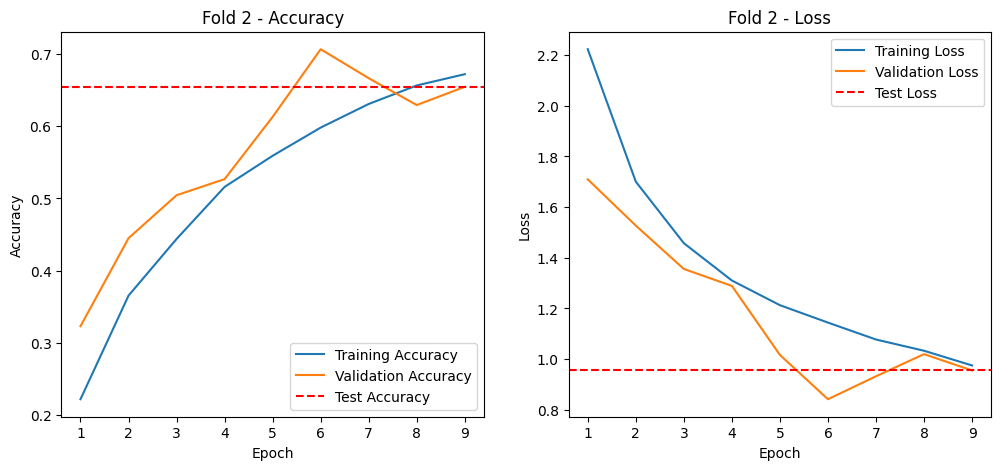

Training on fold 3...
Epoch 1/50


2024-01-31 21:24:26.179137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


336/336 [==============================] - ETA: 0s - loss: 2.2063 - accuracy: 0.2195
Epoch 1: val_accuracy did not improve from 0.77679
336/336 [==============================] - 75s 177ms/step - loss: 2.2063 - accuracy: 0.2195 - val_loss: 1.6981 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 2/50
336/336 [==============================] - ETA: 0s - loss: 1.6809 - accuracy: 0.3787
Epoch 2: val_accuracy did not improve from 0.77679
336/336 [==============================] - 50s 147ms/step - loss: 1.6809 - accuracy: 0.3787 - val_loss: 1.3947 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 3/50
336/336 [==============================] - ETA: 0s - loss: 1.4905 - accuracy: 0.4621
Epoch 3: val_accuracy did not improve from 0.77679
336/336 [==============================] - 49s 145ms/step - loss: 1.4905 - accuracy: 0.4621 - val_loss: 1.4465 - val_accuracy: 0.4271 - lr: 0.0010
Epoch 4/50
336/336 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.5030
Epoch 4: val_accuracy did not imp

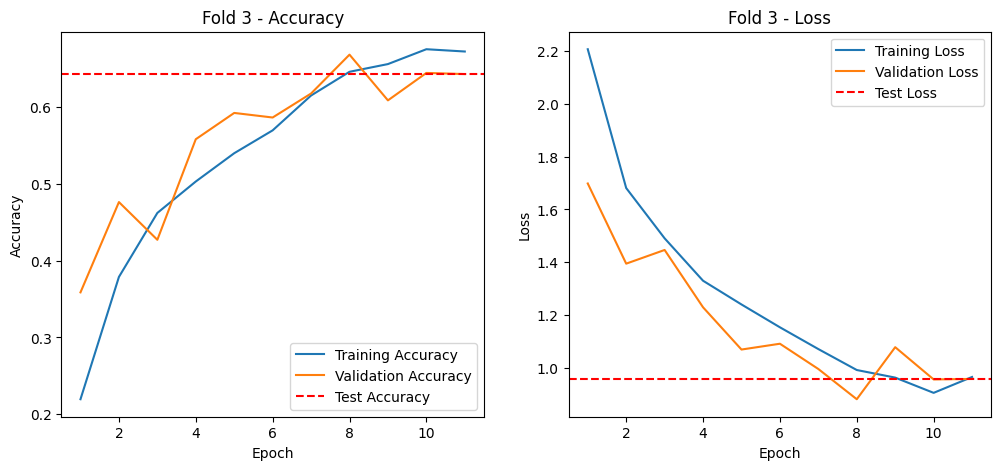

Training on fold 4...
Epoch 1/50


2024-01-31 21:34:41.306779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


336/336 [==============================] - ETA: 0s - loss: 2.1699 - accuracy: 0.2418
Epoch 1: val_accuracy did not improve from 0.77679
336/336 [==============================] - 82s 186ms/step - loss: 2.1699 - accuracy: 0.2418 - val_loss: 1.5736 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 2/50
336/336 [==============================] - ETA: 0s - loss: 1.6223 - accuracy: 0.4003
Epoch 2: val_accuracy did not improve from 0.77679
336/336 [==============================] - 50s 147ms/step - loss: 1.6223 - accuracy: 0.4003 - val_loss: 1.3171 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 3/50
336/336 [==============================] - ETA: 0s - loss: 1.4558 - accuracy: 0.4598
Epoch 3: val_accuracy did not improve from 0.77679
336/336 [==============================] - 53s 157ms/step - loss: 1.4558 - accuracy: 0.4598 - val_loss: 1.3411 - val_accuracy: 0.4970 - lr: 0.0010
Epoch 4/50
336/336 [==============================] - ETA: 0s - loss: 1.3088 - accuracy: 0.5171
Epoch 4: val_accuracy did not imp

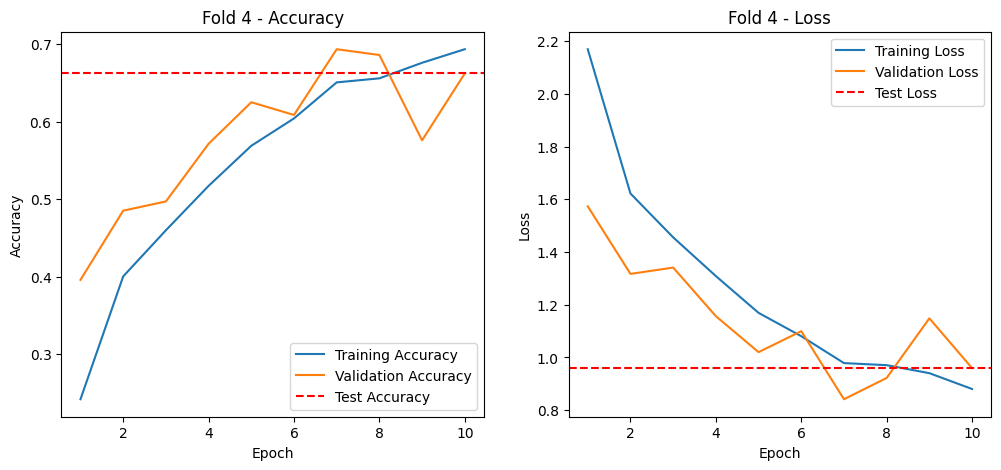

Training on fold 5...
Epoch 1/50


2024-01-31 21:44:29.080849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


336/336 [==============================] - ETA: 0s - loss: 2.2334 - accuracy: 0.2519
Epoch 1: val_accuracy did not improve from 0.77679
336/336 [==============================] - 78s 184ms/step - loss: 2.2334 - accuracy: 0.2519 - val_loss: 1.7960 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 2/50
336/336 [==============================] - ETA: 0s - loss: 1.6494 - accuracy: 0.3895
Epoch 2: val_accuracy did not improve from 0.77679
336/336 [==============================] - 50s 147ms/step - loss: 1.6494 - accuracy: 0.3895 - val_loss: 1.3536 - val_accuracy: 0.4732 - lr: 0.0010
Epoch 3/50
336/336 [==============================] - ETA: 0s - loss: 1.4245 - accuracy: 0.4840
Epoch 3: val_accuracy did not improve from 0.77679
336/336 [==============================] - 49s 147ms/step - loss: 1.4245 - accuracy: 0.4840 - val_loss: 1.1901 - val_accuracy: 0.5446 - lr: 0.0010
Epoch 4/50
336/336 [==============================] - ETA: 0s - loss: 1.2984 - accuracy: 0.5257
Epoch 4: val_accuracy did not imp

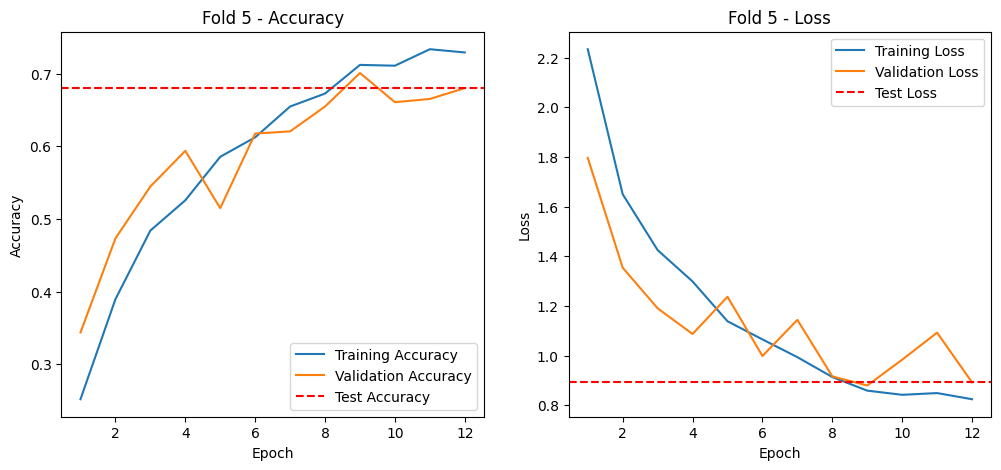

The best model is saved as best_model2.h5.


In [38]:
from tensorflow.keras.backend import clear_session
import gc
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout


n_splits = 5  


skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
best_model_path = 'best_model233.h5'  # 가장 좋은 모델을 저장할 파일 경로

# 가장 좋은 모델을 저장하기 위한 ModelCheckpoint 콜백 설정
model_checkpoint_callback = ModelCheckpoint(
    filepath=best_model_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


for train_index, val_index in skf.split(X_train, np.argmax(y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    meta_train_fold, meta_val_fold = meta_train[train_index], meta_train[val_index]



    # 모델 생성
    model = create_model_with_interactions_inception_v3(input_shape=(224, 224, 3), metadata_shape=(3,), dropout_rate=0.5)
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


    # 모델 학습
    print(f"Training on fold {fold_no}...")
    history = model.fit([X_train_fold, meta_train_fold], y_train_fold, batch_size=8, epochs=50, 
                        validation_data=([X_val_fold, meta_val_fold], y_val_fold),
                        callbacks=[model_checkpoint_callback, reduce_lr, early_stopping])


    # 학습 과정 시각화 
    plot_performance(history, history.history['val_accuracy'][-1], history.history['val_loss'][-1], f"Fold {fold_no}")

    fold_no += 1

    del model  # 모델 삭제
    gc.collect()  # 가비지 컬렉션 실행


# 학습이 끝난 후 가장 좋은 모델 정보 출력
print(f"The best model is saved as {best_model_path}.")


# 테스트 평가

# 성능 리포트 및 혼동행렬 생성

In [39]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 모델 불러오기
loaded_model = load_model('best_model2.h5')

# 테스트 데이터에 모델 적용
test_loss, test_accuracy = loaded_model.evaluate([X_test, meta_test], y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# 테스트 데이터에 대한 예측 수행
y_pred = loaded_model.predict([X_test, meta_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 질환 클래스 이름 매핑 (실제 데이터에 맞게 수정 필요)
class_names = {
    0: '피부 선암 (Actinic keratoses and intraepithelial carcinoma)',
    1: '기저세포암 (Basal cell carcinoma)',
    2: '벤인 케라토시스 라이크 레이즈니즈 (Benign keratosis-like lesions)',
    3: '피부 섬유종 (Dermatofibroma)',
    4: '흑색종 (Melanoma)',
    5: '멜라닌성 낭종 (Melanocytic nevi)',
    6: '혈관 질환 (Vascular lesions)'
}

# 성능 리포트 생성
report = classification_report(y_true, y_pred_classes, target_names=list(class_names.values()))
print("분류 리포트:\n", report)




27/27 [==============================] - 7s 199ms/step - loss: 0.6793 - accuracy: 0.7702
Test Accuracy: 77.02%
Test Loss: 0.6793
27/27 [==============================] - 7s 173ms/step
분류 리포트:
                                                          precision    recall  f1-score   support

피부 선암 (Actinic keratoses and intraepithelial carcinoma)       0.81      0.53      0.64       120
                           기저세포암 (Basal cell carcinoma)       0.85      0.83      0.84       120
     벤인 케라토시스 라이크 레이즈니즈 (Benign keratosis-like lesions)       0.56      0.73      0.63       120
                                피부 섬유종 (Dermatofibroma)       0.84      0.95      0.89       120
                                         흑색종 (Melanoma)       0.59      0.74      0.66       120
                             멜라닌성 낭종 (Melanocytic nevi)       0.95      0.60      0.73       120
                               혈관 질환 (Vascular lesions)       0.98      1.00      0.99       120

                             

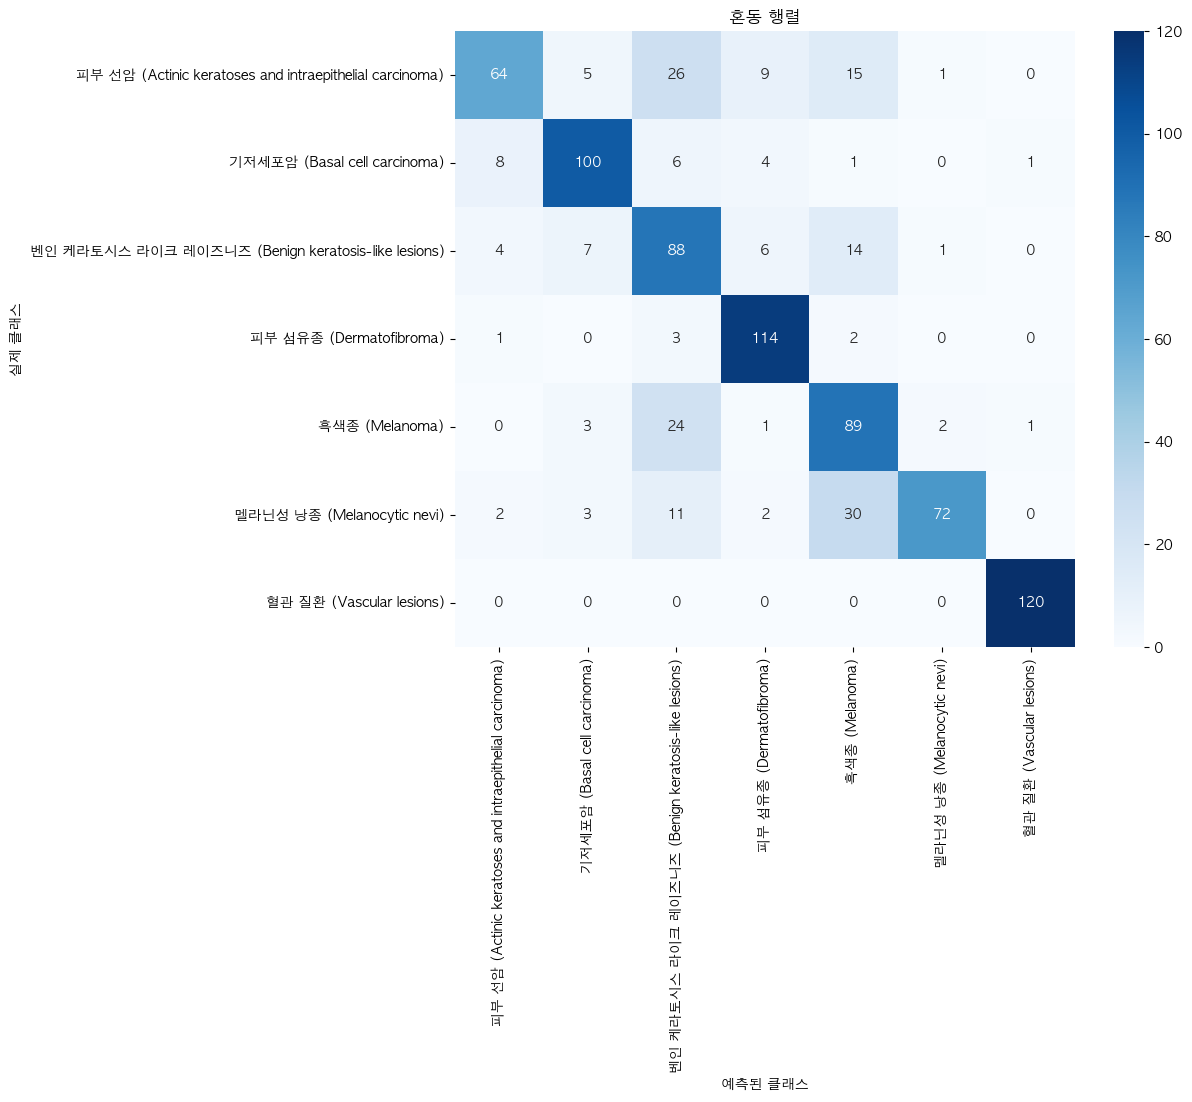

In [40]:

import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['font.family'] = 'AppleGothic'

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel('예측된 클래스')
plt.ylabel('실제 클래스')
plt.title('혼동 행렬')
plt.show()


# 메타데이터를 입력받고 이미지를 업로드하였을 때 예측 값 구하기

In [14]:
import cv2
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder

# 함수 정의
def load_metadata(file_path):
    return pd.read_csv(file_path)

def get_user_input():
    age = float(input("나이를 입력하세요: "))
    sex_input = input("성별을 입력하세요 (남자/여자): ")
    localization_input = input("질환 부위를 입력하세요 (예: 얼굴, 머리): ")
    return age, sex_input, localization_input

def encode_user_input(metadata_df, age, sex_input, localization_input):
    sex_dict = {"남자": "male", "여자": "female"}
    # 질환 부위를 영어로 변환
    localization_dict = {
        "복부": "abdomen",
        "등": "back",
        "가슴": "chest",
        "얼굴": "face",
        "발": "foot",
        "생식기": "genital",
        "다리": "lower extremity",
        "목": "neck",
        "두피": "scalp",
        "몸통": "trunk",
        "알수없음": "unknown",
        "팔": "upper extremity",
        "귀" : "ear",
        "손바닥" : "acral",
        "손" : "hand",
    }
    sex = sex_dict.get(sex_input, "unknown")
    localization = localization_dict.get(localization_input, "unknown")
    sex_encoded = 0 if sex == "male" else 1
    label_encoder = LabelEncoder().fit(metadata_df['localization'])
    localization_encoded = label_encoder.transform([localization])[0]
    return np.array([[age, sex_encoded, localization_encoded]])

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # 이미지를 [0, 1] 범위로 정규화
    return np.expand_dims(img_array, axis=0)

def predict_skin_disease(model, img_array, meta_input):
    # 모델에 두 개의 입력을 제공
    predictions = model.predict([img_array, meta_input])
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names.get(predicted_class_index, "알 수 없음")
    predicted_class_probability = predictions[0][predicted_class_index]
    return predicted_class_index, predicted_class_name, predicted_class_probability

# 질환 클래스 이름 매핑 (실제 데이터에 맞게 수정 필요)
class_names = {
    0: '피부 선암 (Actinic keratoses and intraepithelial carcinoma)',
    1: '기저세포암 (Basal cell carcinoma)',
    2: '벤인 케라토시스 라이크 레이즈니즈 (Benign keratosis-like lesions)',
    3: '피부 섬유종 (Dermatofibroma)',
    4: '흑색종 (Melanoma)',
    5: '멜라닌성 낭종 (Melanocytic nevi)',
    6: '혈관 질환 (Vascular lesions)'
}

# 메타데이터 로드
metadata_df = load_metadata('HAM10000_metadata.csv')

# 모델 로드
model = load_model('/Users/choejong-gyu/Documents/GitHub/skindisease2/dense201_0125.h5')

# 사용자 입력 받기
age, sex_input, localization_input = get_user_input()

# 입력 데이터 인코딩
meta_input = encode_user_input(metadata_df, age, sex_input, localization_input)

# 이미지 처리
image_path = '/Users/choejong-gyu/Downloads/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0073254.jpg'  # 실제 이미지 경로로 변경
img_array = preprocess_image(image_path)

# 예측 수행
predicted_class_index, predicted_class_name, predicted_class_probability = predict_skin_disease(model, img_array, meta_input)

# 결과 출력
print(f"예측된 피부 질환 클래스 인덱스: {predicted_class_index}")
print(f"예측된 피부 질환 클래스 이름: {predicted_class_name}")
print(f"예측된 피부 질환 클래스 확률: {predicted_class_probability:.4f}")


1/1 [==============================] - 1s 1s/step
예측된 피부 질환 클래스 인덱스: 3
예측된 피부 질환 클래스 이름: 피부 섬유종 (Dermatofibroma)
예측된 피부 질환 클래스 확률: 0.7941
